In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import package
from shap_explainer import ShapDeepExplainer
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import os

2024-01-28 13:35:08.200061: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 13:35:08.246505: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 13:35:08.246539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 13:35:08.247792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 13:35:08.255770: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# load data
os.chdir('./titanic/')
train_data = pd.read_csv('./train.csv', index_col=0)
test_data = pd.read_csv('./test.csv', index_col=0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def data_preprocessing(df):
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
    
    # fill na
    df[['Age']] = df[['Age']].fillna(value=df[['Age']].mean())
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())
    df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())
    
    # categorical features into numeric
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    # one-hot encoding
    embarked_one_hot = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = df.drop('Embarked', axis=1)
    df = df.join(embarked_one_hot)
    
    return df
# train data processing
train_data = data_preprocessing(train_data)
train_data.isnull().sum()
# create data for training
x_train = train_data.drop(['Survived'], axis=1).values
# Check test data
test_data.isnull().sum()
# scale
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
# prepare y_train
y_train = train_data['Survived'].values
test_data = data_preprocessing(test_data)
x_test = test_data.values.astype(float)
# scaling
x_test = scale.transform(x_test)
# Check test data
test_data.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [5]:
# build mlp
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# fit model
model.fit(x_train, y_train, epochs=10, batch_size=64)

2024-01-28 13:35:17.152045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-01-28 13:35:17.152787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22835 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:86:00.0, compute capability: 7.5
2024-01-28 13:35:17.153363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22835 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:af:00.0, compute capability: 7.5


Epoch 1/10


2024-01-28 13:35:20.550257: I external/local_xla/xla/service/service.cc:168] XLA service 0x563990a955b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-28 13:35:20.550300: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-01-28 13:35:20.550309: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2024-01-28 13:35:20.550316: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): Quadro RTX 6000, Compute Capability 7.5
2024-01-28 13:35:20.558650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-28 13:35:20.681842: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1706448920.811462   51185 device_compiler.h:1

14/14 [==============================] - 5s 8ms/step - loss: 0.6623 - accuracy: 0.6218
Epoch 2/10
14/14 [==============================] - 0s 7ms/step - loss: 0.6254 - accuracy: 0.6510
Epoch 3/10
14/14 [==============================] - 0s 6ms/step - loss: 0.5591 - accuracy: 0.7048
Epoch 4/10
14/14 [==============================] - 0s 6ms/step - loss: 0.5501 - accuracy: 0.7093
Epoch 5/10
14/14 [==============================] - 0s 7ms/step - loss: 0.5327 - accuracy: 0.7452
Epoch 6/10
14/14 [==============================] - 0s 6ms/step - loss: 0.5185 - accuracy: 0.7486
Epoch 7/10
14/14 [==============================] - 0s 7ms/step - loss: 0.5022 - accuracy: 0.7778
Epoch 8/10
14/14 [==============================] - 0s 7ms/step - loss: 0.5066 - accuracy: 0.7722
Epoch 9/10
14/14 [==============================] - 0s 7ms/step - loss: 0.4887 - accuracy: 0.7565
Epoch 10/10
14/14 [==============================] - 0s 7ms/step - loss: 0.4921 - accuracy: 0.7800


In [54]:
explainer = ShapDeepExplainer(model, x_train, feature_names=test_data.columns)
shap_values = explainer.explain(x_test)

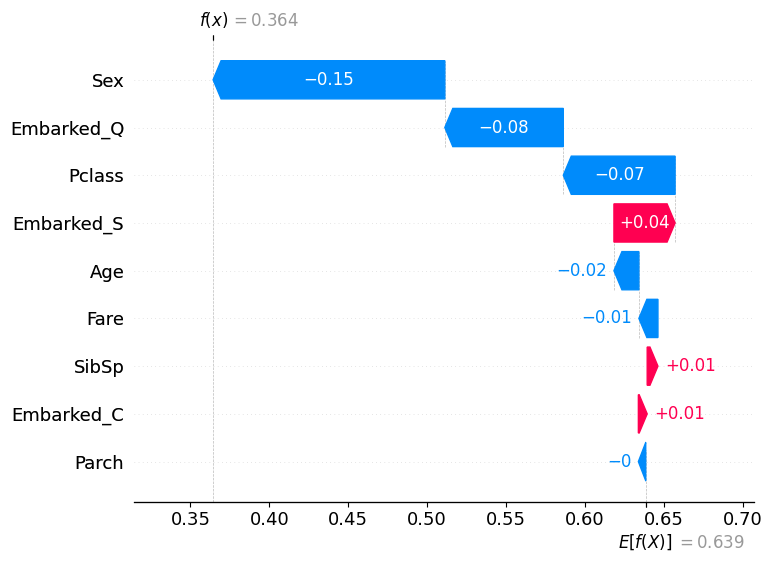

In [40]:
explainer.waterfall(shap_values[0])

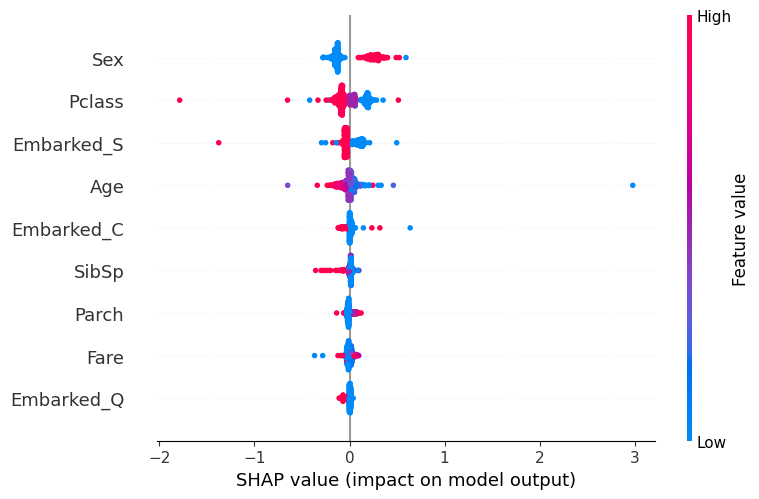

In [41]:
explainer.beeswarm(shap_values, test_data)

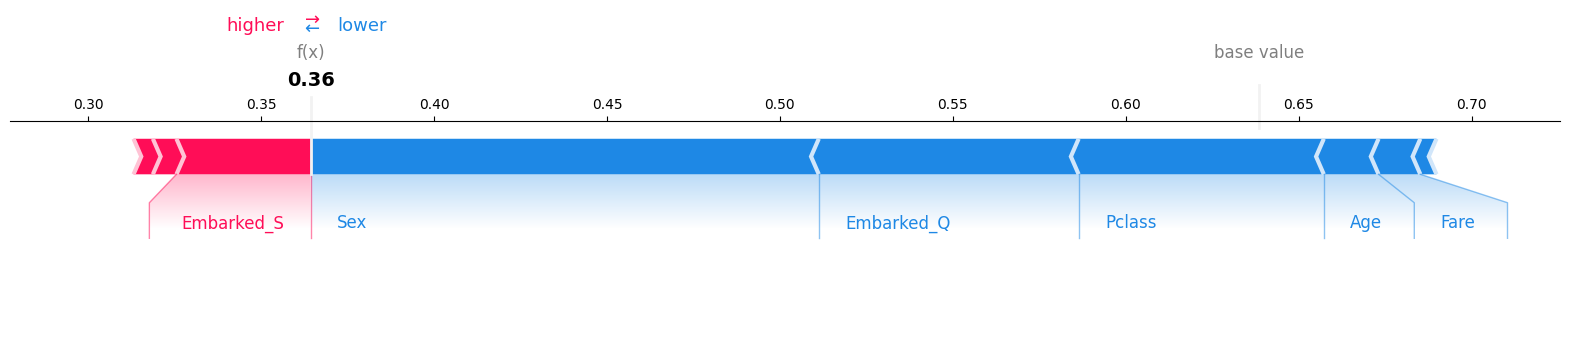

In [42]:
explainer.force(shap_values[0])

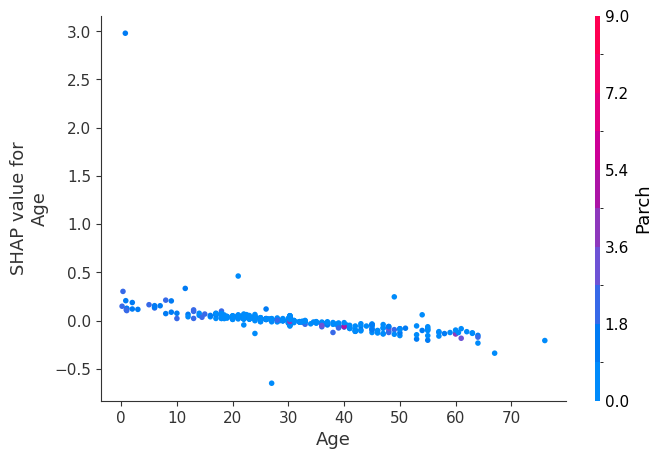

In [56]:
explainer.dependence_plot('Age', shap_values, test_data, interaction_index='auto')